# Определение параметров успешной игры

Из открытых источников нам доступны исторические данные о продажах игр до 2016 года, оценки пользователей и экспертов, жанры и платформы . Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Описание данных:
 - name — название игры
 - platform — платформа
 - release_year — год выпуска
 - genre — жанр игры
 - na_sales — продажи в Северной Америке (миллионы проданных копий)
 - eu_sales — продажи в Европе (миллионы проданных копий)
 - jp_sales — продажи в Японии (миллионы проданных копий)
 - other_sales — продажи в других странах (миллионы проданных копий)
 - critic_score — оценка критиков (максимум 100)
 - user_score — оценка пользователей (максимум 10)
 - rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация   определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Подготовка

#### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# !pip install plotly==4.14.3
import plotly.express as px
import plotly
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
from scipy import stats as st

viewing_jpg = True
if viewing_jpg:
    import plotly.io as pio
    jpg_renderer = pio.renderers['jpg']
    pio.renderers.default='jpg'
    jpg_renderer.width = 950
    jpg_renderer.height = 550

#### Необходимые функции

In [2]:
# Различие между оценками пользователей и критиков
def score(row):
    try:
        return row['critic_score'] - row['user_score'] * 10
    except:
        return np.nan


# Разделение на категории по брендам
def brend(row):
    if row.platform in ['PS2', 'PS3', 'PSP', 'PS', 'PSV', 'PS4']:
        return 'PlayStation'
    if row.platform in ['DS', 'Wii', 'GBA', '3DS', 'N64', 'WiiU', 'SNES', 'GB', 'DC', 'GC']:
        return 'Nintendo'
    if row.platform in ['X360', 'XB', 'XOne']:
        return 'Xbox'
    if row.platform in ['PC']:
        return 'PC'
    else:
        return 'прочие'
    

# График распределения продаж по годам
def my_line(brend_name):
    fig = px.line(brends[brends['brend'] == brend_name],\
              x='release_year', y='total_sales', color='platform',\
              labels=dict(total_sales='Количество продаж, млн. копий', release_year='Год'))
    fig.update_layout(title={'text': 'Распределение продаж по бренду ' + brend_name,\
                             'y':0.94, 'x':0.5})
    fig.show()
    

# Корреляция между оценками и продажами
def my_corr_score(platf, upper_fence):
    fig = px.scatter_matrix(df_top3[(df_top3['platform'] == platf)\
                                   & (df_top3['total_sales'] <= upper_fence)],\
                        dimensions=['user_score', 'critic_score', 'total_sales'],\
                        color='total_sales', width=780, height=670,\
                        labels=dict(total_sales='продажи, млн.копий',\
                                    user_score='оценки пользователей',
                                    critic_score='оценки критиков'))
    fig.update_layout(title=\
                {'text': 'Матрица корреляции между оценками и продажами по платформе ' + platf,\
                         'y':0.96, 'x':0.49})
    fig.show()
    corr = df_top3[(df_top3['platform'] == platf) & (df_top3['total_sales'] <= upper_fence)]\
        [['user_score', 'critic_score', 'total_sales']].corr()
    display(corr.style.background_gradient(cmap='BuGn'))
    

# Топ-5
def top5(group, col, name1, name2, name3):
    my_top = group.sort_values(by='na_sales', ascending=False)\
            .reset_index().head(5).loc[:, [col, 'na_sales']]\
            .rename(columns={col: name1})\
            .merge(group.sort_values(by='eu_sales', ascending=False)\
                .reset_index().head(5).loc[:, [col, 'eu_sales']]\
                .rename(columns={col: name2}), left_index=True, \
                   right_index=True, how='left')\
            .merge(group.sort_values(by='jp_sales', ascending=False)\
                .reset_index().head(5).loc[:, [col, 'jp_sales']]\
                .rename(columns={col: name3}), left_index=True,\
                   right_index=True, how='left')\
            .reset_index()\
            .rename(columns = {'index': 'rating'})
    my_top.rating += 1
    display(my_top)
    
    
# Соотношение продаж по регионам
def top_visual(datta, coll):
    fig = go.Figure(data=[
        go.Bar(name='Северная Америка', x=datta[coll], y=datta.na_sales),
        go.Bar(name='Европа', x=datta[coll], y=datta.eu_sales),
        go.Bar(name='Япония', x=datta[coll], y=datta.jp_sales)])
    fig.update_traces(marker_line_color='rgb(10,50,100)')
    fig.update_layout(title={'text': 'Соотношение продаж по регионам',\
                             'y':0.89, 'x':0.44})
    fig.show()
    
    
# График "Ящик с усами"
def my_yc(dff, xx, yy):
    fig = px.box(dff, x=xx, y=yy, points='all')
    fig.update_layout(title={'text': 'График "ящик с усами"',\
                         'y':0.95, 'x':0.49})
    fig.show()

### Изучение общей информации

#### Общая информация

In [3]:
try:
    my_df = pd.read_csv('/datasets/games.csv')
except:
    my_df = pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\04_games.csv')

Выведем общую информацию по таблице

In [4]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Для удобства сразу заменим наименования столбцов

In [5]:
my_df.columns = my_df.columns.str.lower()
my_df = my_df.rename(columns={'year_of_release': 'release_year'})

Изучим первые и последнии 5 строк

In [6]:
display(my_df.head())
display(my_df.tail())

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


Проверим наличие дубликатов

In [7]:
print('Количество полных дубликатов:', my_df.duplicated().sum())
print('Количество дубликатов по первым трем столбцам:', \
     my_df.loc[:, ['name', 'platform', 'release_year']].duplicated().sum())

Количество полных дубликатов: 0
Количество дубликатов по первым трем столбцам: 2


Выведем эти 2 строки

In [8]:
display(my_df[my_df.loc[:, ['name', 'platform', 'release_year']].duplicated()])

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


Проверим уникальные значения столбца "platform"

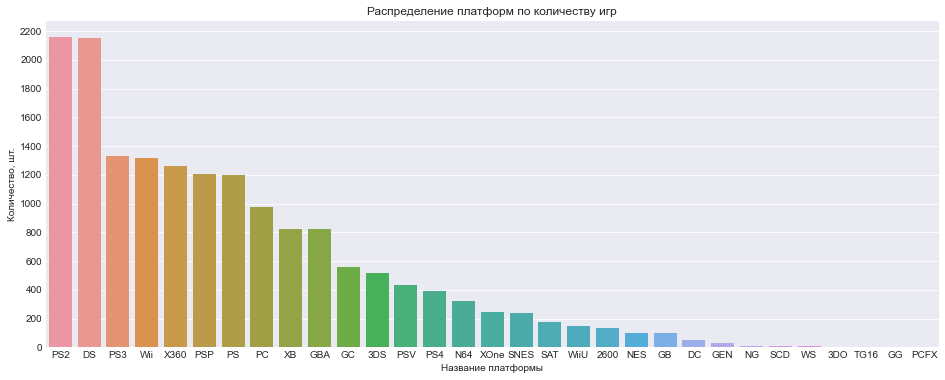

In [9]:
mpl.style.use(['seaborn-darkgrid'])
plt.figure(figsize=(16, 6))
sns.barplot(x=my_df.platform.value_counts().index, y=my_df.platform.value_counts())
plt.title('Распределение платформ по количеству игр')
plt.xlabel('Название платформы')
plt.ylabel('Количество, шт.')
plt.yticks(np.arange(0, 2201, 200))
plt.show()

Изучим распределение релиза игр по годам

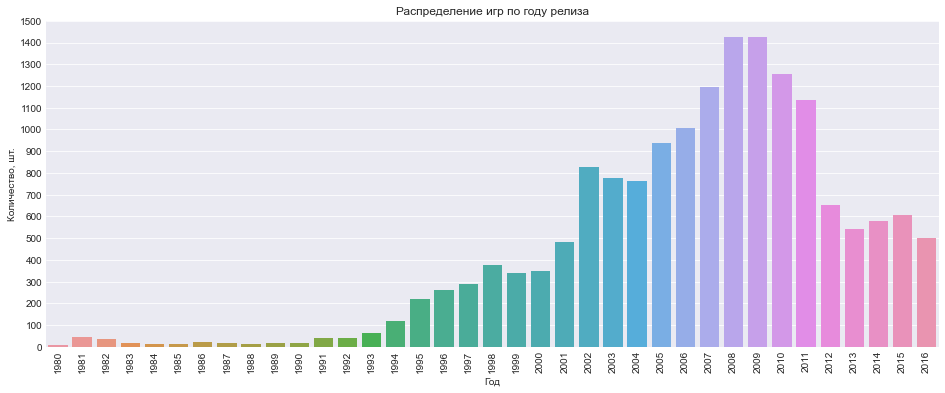

In [10]:
plt.figure(figsize=(16, 6))
sns.barplot(x=my_df.release_year.value_counts().index.astype('int16'), \
            y=my_df.release_year.value_counts())
plt.title('Распределение игр по году релиза')
plt.xlabel('Год')
plt.ylabel('Количество, шт.')
plt.yticks(np.arange(0, 1501, 100))
plt.xticks(rotation=90)
plt.show()

Изучим игровые жанры

In [11]:
display(my_df.groupby('genre')['name'].count().reset_index())

,genre,name
0,Action,3369
1,Adventure,1303
2,Fighting,849
3,Misc,1750
4,Platform,888
5,Puzzle,580
6,Racing,1249
7,Role-Playing,1498
8,Shooter,1323
9,Simulation,873


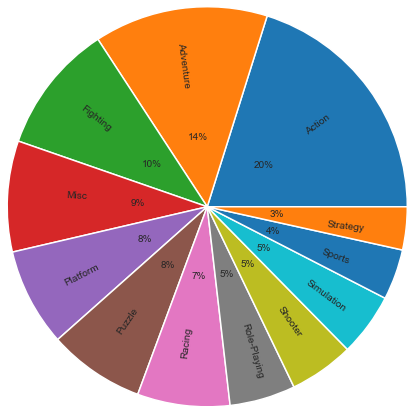

In [12]:
plt.pie(my_df.groupby('genre')['name'].count().sort_values(ascending=False).reset_index().name, \
        labels=my_df.groupby('genre')['name'].count().reset_index().genre,\
        labeldistance=0.6, pctdistance=0.35, autopct='%1.0f%%', radius=2.3, rotatelabels=True,\
        wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white' })
plt.show()

Выведем основные статистические показатели по продажам копий игр в разных регионах

In [13]:
display(my_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe())

,na_sales,eu_sales,jp_sales,other_sales
count,16715.000000,16715.000000,16715.000000,16715.000000
mean,0.263377,0.145060,0.077617,0.047342
std,0.813604,0.503339,0.308853,0.186731
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Изучим распределение оценок критиков

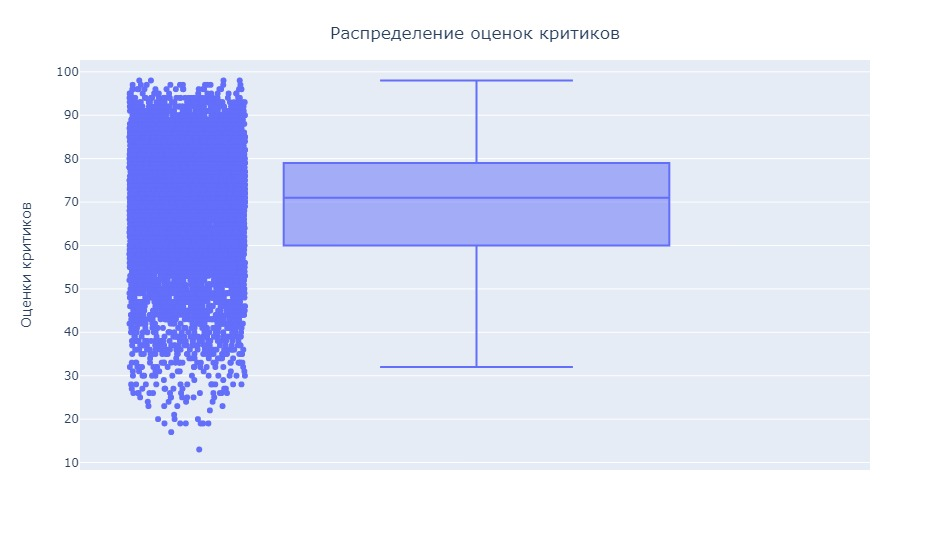

<Figure size 576x576 with 0 Axes>

In [14]:
plt.figure(figsize=(8, 8))
fig = px.box(my_df, y='critic_score',  points='all', width=700, height=600, \
            labels=dict(critic_score='Оценки критиков'))
fig.update_layout(title={'text': 'Распределение оценок критиков', 'y':0.95, 'x':0.5})
fig.show()

Изучим уникальные значения столбца "user_score"

In [15]:
display(my_df.user_score.unique())

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Посчитаем количество строк с значениями "tbd" и "0" в столбце "user_score"

In [16]:
print('Количество строк в столбце "user_score" с значением "tbd":',\
      len(my_df.query('user_score == "tbd"')))
print('Количество строк в столбце "user_score" с значением 0:',\
      len(my_df.query('user_score == "0"')))

Количество строк в столбце "user_score" с значением "tbd": 2424
Количество строк в столбце "user_score" с значением 0: 1


Изучим несколько строк с значением "tbd" в столбце "user_score"

In [17]:
display(my_df.query('user_score == "tbd"').sample(10))

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11916,Elements of Destruction,DS,2007.0,Strategy,0.07,0.00,0.00,0.01,NaN,tbd,E10+
12163,Titanic Mystery,DS,2010.0,Puzzle,0.05,0.01,0.00,0.01,NaN,tbd,T
8652,Dragon Ball: Origins 2,DS,2010.0,Action,0.05,0.01,0.08,0.01,70.0,tbd,T
10719,Cate West: The Vanishing Files,DS,2008.0,Adventure,0.08,0.01,0.00,0.01,68.0,tbd,E10+
3520,Rapala: We Fish,Wii,2009.0,Sports,0.52,0.01,0.00,0.04,NaN,tbd,E
7381,Bratz: Girlz Really Rock,Wii,2008.0,Action,0.19,0.00,0.00,0.02,NaN,tbd,E
9299,Fashion Studio: Paris Collection,DS,2009.0,Misc,0.13,0.00,0.00,0.01,NaN,tbd,E
9378,Rogue Ops,XB,2003.0,Action,0.10,0.03,0.00,0.00,63.0,tbd,M
3536,Trivial Pursuit,Wii,2009.0,Misc,0.20,0.30,0.00,0.07,67.0,tbd,E
8832,Build-A-Bear Workshop: Welcome to Hugsville,DS,2010.0,Misc,0.14,0.00,0.00,0.01,NaN,tbd,E


Изучим распределение игр по рейтингу от организации ESRB

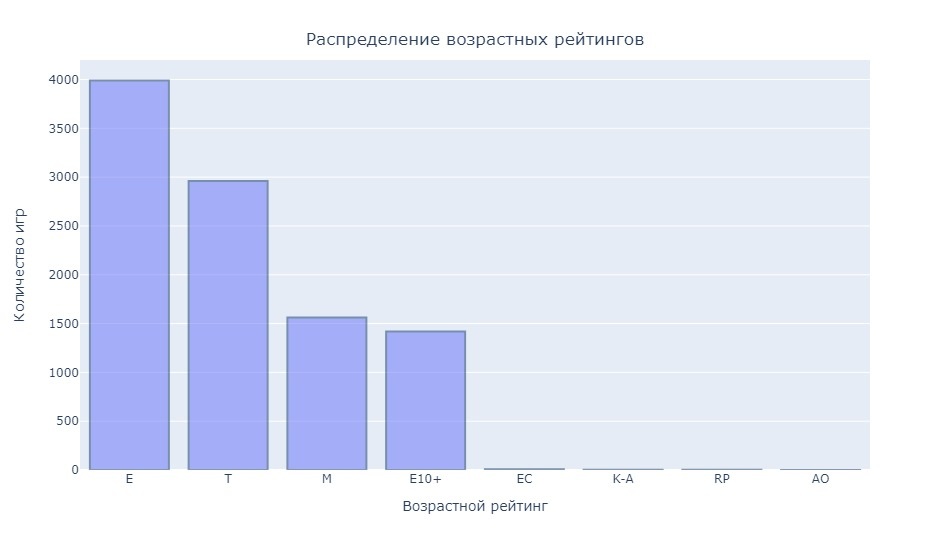

In [18]:
fig = px.bar(my_df.groupby('rating')['name'].count().sort_values(ascending=False).reset_index(),\
             x='rating', y='name',\
             labels=dict(name='Количество игр', rating='Возрастной рейтинг'))
fig.update_traces(marker_line_color='rgb(10,50,100)', marker_line_width=2, opacity=0.5)
fig.update_layout(title={'text': 'Распределение возрастных рейтингов', 'y':0.94, 'x':0.5})
fig.show()

In [19]:
data_ESRB = [['EC', 'Игра подходит для детей от 3 лет и старше'],\
             ['E', 'Игра подходит для возрастной категории старше 6 лет'],\
             ['E10+', 'Игра подходит для возрастной категории старше 10 лет'],\
             ['T', 'Игра подходит для подростков старше 13 лет'],\
             ['M', 'Игра подходит для возрастной категории старше 17 лет'],\
             ['AO', 'Игра подходит только для взрослых'],\
             ['RP', 'Продукт был отправлен в ESRB и ожидает присвоение рейтинга'],\
             ['K-A', 'Этот рейтинг использовался до 1998 года, когда он был переименован в E']]
ESRB = pd.DataFrame(data=data_ESRB, columns=['Рейтинг ESRB', 'Расшифровка'])
pd.set_option('max_colwidth', 140)
ESRB = ESRB.style.set_properties(**{'text-align': 'left'})
display(ESRB)

,Рейтинг ESRB,Расшифровка
0,EC,Игра подходит для детей от 3 лет и старше
1,E,Игра подходит для возрастной категории старше 6 лет
2,E10+,Игра подходит для возрастной категории старше 10 лет
3,T,Игра подходит для подростков старше 13 лет
4,M,Игра подходит для возрастной категории старше 17 лет
5,AO,Игра подходит только для взрослых
6,RP,Продукт был отправлен в ESRB и ожидает присвоение рейтинга
7,K-A,"Этот рейтинг использовался до 1998 года, когда он был переименован в E"


#### Вывод

- В столбце "name" кроме двух пропущенных наименований игр все корректно. Два пропущенных значения являются дубликатами друг друга и не несут почти никакой информации по остальным столбцам. Необходимо удалить эти строки.
- В столбце "platform" отмечена 31 уникальная платформа. Пропусков нет. Необходимо перевести тип данных в категориальный.
- В столбце "release_year" 1.5% пропущенных значений. Ввиду дальнейшего плотного участия данного столбца в анализе, невозможности заполнить пропуски какими либо значениями (единственный вариант по каждой игре искать год релиза и вручную заполнять пропуски, но на это уйдет уйма времени), а так же незначительного объема пропусков, считаю необходимым удалить данные строки. После этого необходимо изменить тип данных на int16.
- В столбце "genre" расположено 12 уникальных игровых жанров. Всего 2 пропуска, которые относятся к пропускам в столбце "name". После удаления строк с пропусками необходимо перевести тип данных в категориальный.
- В столбцах "na_sales", "eu_sales", "jp_sales" и "other_sales" все корректно, тип данных подходящий, пропуски отсутствуют.
- В стобце "critic_score" 51% пропущенных значений. После обработки пропусков можно изменить тип данных на int8.
- В столбце "user_score" 40% пропущенных значений. Кроме того 14.5% значений имеют значение "tbd" в данном столбце. Как выяснилось значение "tbd" расшифровывается как "To Be Determined" и переводится как "Будет определено". Просмотрев несколько случайных строк обнаружил что игры с значением "tbd" в оценке пользователей выходили на разных платформах в разные года, т.е. необъяснимо почему игра вышедшая, например, в 2001 году до сих пор не получила оценку пользователей, хоть и было продано более 200000 копий. Просмотрев информацию на просторах интернета по нескольким рандомно выбранным играм обнаружил, что часть из них до сих пор имеют в качестве оценки пользователей значение "tbd". Пока не понятно как заполнять пропуски, и стоит ли это делать.
- В столбце "rating" 40% пропущенных значений и 8 уникальных возрастных категорий. Нет возможности заполнить пропущенные значения, поэтому анализ будем проводить с участием строк без пропусков в данном столбце. Кроме того необходимо заменить рейтинг "RP" на nan, так как по сути это то же самое неизвестное значение, а так же заменить рейтинг "K-A" на рейтинг "E", так как рейтинг "K-A" в 1998 году переименовали в рейтинг "E".

### Предобработка данных

#### Обработка дубликатов

Ранее мы обнаружили два дубликата, один из них в паре со своим повтором не несет никакой полезной информации, поэтому удалим их оба при помощи метода dropna(), второй удалим в единственном экземпляре.

In [20]:
my_df.dropna(subset=['name'], inplace=True)
my_df = my_df.drop(index=[16230]).reset_index(drop=True)

#### Обработка пропусков

В столбце "release_year" 1.5% пропущенных значений. Пропуски невозможно заполнить, а данный столбец будет активно участвовать в анализе. Объем незначительный, удалим строки с пропусками в столбце "release_year".

In [21]:
my_df.dropna(subset=['release_year'], inplace=True)
my_df = my_df.reset_index(drop=True)

Теперь посмотрим что можно сделать с пропусками в столбцах "user_score" и "critic_score". Заменим значение "tbd" на "NaN", так как оно по сути и является неизвестной оценкой, изменим тип данных столбца "user_score" на "float" и изучим корреляцию между количественными переменными.

In [22]:
my_df.user_score = my_df.user_score.replace('tbd', np.nan).astype('float')
display(my_df.corr())

,release_year,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
release_year,1.000000,-0.092311,0.004060,-0.168468,0.037837,0.011268,-0.267745
na_sales,-0.092311,1.000000,0.766545,0.451159,0.638478,0.240150,0.085498
eu_sales,0.004060,0.766545,1.000000,0.435892,0.722678,0.221330,0.055487
jp_sales,-0.168468,0.451159,0.435892,1.000000,0.291559,0.153510,0.126351
other_sales,0.037837,0.638478,0.722678,0.291559,1.000000,0.198461,0.056895
critic_score,0.011268,0.240150,0.221330,0.153510,0.198461,1.000000,0.579920
user_score,-0.267745,0.085498,0.055487,0.126351,0.056895,0.579920,1.000000


Максимальная корреляция достигается как раз между оценками критиков и пользователей. Но в обоих столбцах имеется большое количество пропусков. Проверим количество строк которые можно попытаться восстановить.

In [23]:
display(len(my_df[(my_df['critic_score'].isna() == False) & (my_df['user_score'].isna())]) +\
        len(my_df[(my_df['critic_score'].isna()) & (my_df['user_score'].isna() == False)]))

1658

Возможно нам удастся восстановить 10% данных по оценкам критиков и пользователей. При помощи функции "score" добавим в таблицу столбец разности оценок и выведем гистограмму распределения различия оценок критиков и оценок пользователей.

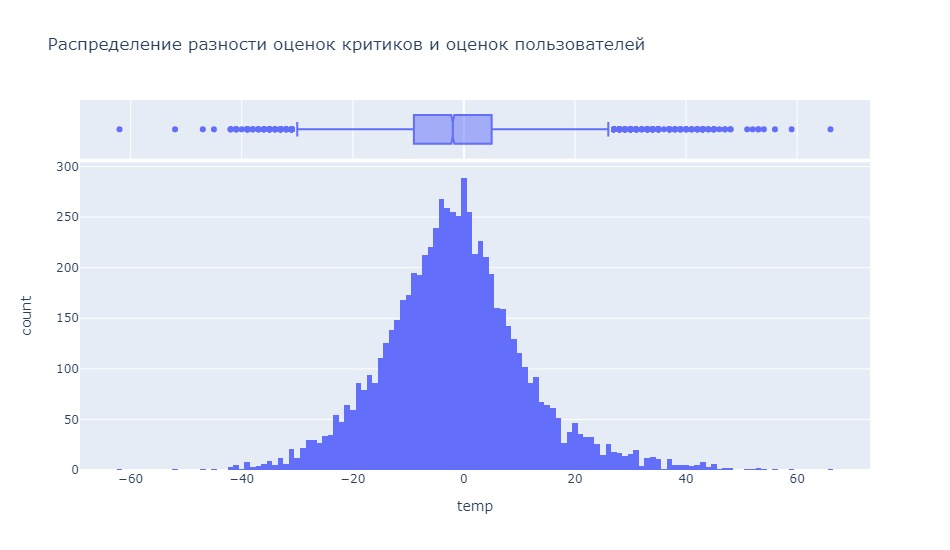

In [24]:
my_df['temp'] = my_df.apply(score, axis=1)
fig = px.histogram(my_df, x = 'temp', marginal = 'box',\
                   title = 'Распределение разности оценок критиков и оценок пользователей')
fig.show()

К сожалению разброс слишком велик для использования столбцов "user_score" и "critic_score" для заполнения пропусков в них, можно грубо ошибиться, а корреляция с остальными параметрами незначительна. Принимаю решение оставить данные столбцы с пропусками, а анализ с использованием этих столбцов проводить без учета пропусков. Удалимвременный столбец "temp", он нам больше не нужен.

In [25]:
my_df = my_df.drop(['temp'], axis = 1)

Ранее по столбцу "rating" мы приняли решение оставить его как есть ввиду невозможности заполнить пропуски, но все же заменим пропущенные значения на "ND" (not defined). Так же необходимо заменить рейтинг "RP" на "ND", так как по сути это те же самые неопределенные значение, а так же заменить рейтинг "K-A" на рейтинг "E", так как рейтинг "K-A" в 1998 году переименовали в рейтинг "E". Кроме того причислим игры с рейтингом "EC" и "AO" к ближайшим рейтингам "Е" и "M" соответственно, так как нет смысла анализировать всего 9 игр с данными рейтингами. После замены выведем уникальные значения столбца для проверки

In [26]:
my_df.rating = my_df.rating.fillna('ND')
my_df.rating = my_df.rating.replace(['RP', 'K-A', 'EC', 'AO'], ['ND', 'E', 'E', 'M'])
display(my_df.rating.value_counts())

ND      6677
E       3931
T       2905
M       1537
E10+    1393
Name: rating, dtype: int64

Замена прошла успешно. Выведем общую информацию по таблице.

In [27]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16443 non-null  object 
 1   platform      16443 non-null  object 
 2   release_year  16443 non-null  float64
 3   genre         16443 non-null  object 
 4   na_sales      16443 non-null  float64
 5   eu_sales      16443 non-null  float64
 6   jp_sales      16443 non-null  float64
 7   other_sales   16443 non-null  float64
 8   critic_score  7982 non-null   float64
 9   user_score    7462 non-null   float64
 10  rating        16443 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


#### Замена типов данных

Согласно вывода раздела 2 заменим типы данных на необходимые а так же приведем оценки пользователей и критиков к единой единице измерения. Для проверки снова выведем общую информацию по таблице.

In [28]:
my_df['rating'] = my_df['rating'].astype('category')
my_df['release_year'] = my_df['release_year'].astype('int16')
my_df['user_score'] = my_df['user_score'] * 10

In [29]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          16443 non-null  object  
 1   platform      16443 non-null  object  
 2   release_year  16443 non-null  int16   
 3   genre         16443 non-null  object  
 4   na_sales      16443 non-null  float64 
 5   eu_sales      16443 non-null  float64 
 6   jp_sales      16443 non-null  float64 
 7   other_sales   16443 non-null  float64 
 8   critic_score  7982 non-null   float64 
 9   user_score    7462 non-null   float64 
 10  rating        16443 non-null  category
dtypes: category(1), float64(6), int16(1), object(3)
memory usage: 1.2+ MB


#### Добавление необходимых столбцов

Для дальнейшего анализа добавим в таблицу столбец с суммарными продажами для кажой игры и выведем первые 5 строк для проверки

In [30]:
my_df['total_sales'] = my_df.iloc[:, 4:8].sum(1)
display(my_df.head())

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,ND,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,ND,31.38


Сохраним в отдельной переменной копию таблицы с которой далее будем проводить анализ

In [31]:
df_main = my_df.copy()

### Исследовательский анализ данных

#### Анализ распределения релиза игр по годам

Повторно выведем график распределения релиза игр по годам

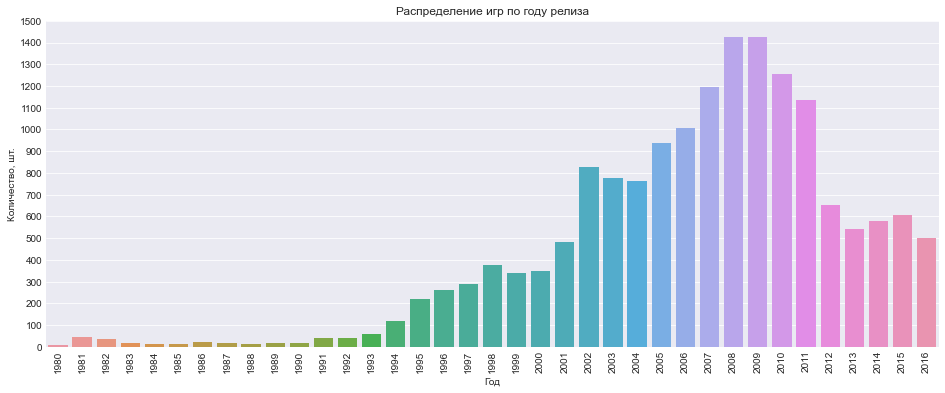

In [32]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df_main.release_year.value_counts().index, \
            y=df_main.release_year.value_counts())
plt.title('Распределение игр по году релиза')
plt.xlabel('Год')
plt.ylabel('Количество, шт.')
plt.yticks(np.arange(0, 1501, 100))
plt.xticks(rotation=90)
plt.show()

Как видно на графике период выхода игр можно разделить на две части:
- До 1994 года, когда игры выходили менее 100 шт в год
- Начиная с 1994 года, когда количество релизов превышало 100 в год

Считаю что ввиду малого количества информации по каждому году до 1994 года необходимо ограничить выборку по дате релиза от 1994 года, врятли более раннии релизы будут нам полезны в анализе. Так же можно отметить, что в период с 2007 года по 2011 год включительно ежегодно выпускалось игр заметно больше чем в остальные года. До 2008 года количество выпускаемых игр постепенно увеличилось, и начиная с 2010 по 2012 год количество выпускаемых игр резко сократилось и вплоть до 2016 года оставалось на одном уровне.

In [33]:
df_main = df_main.query('release_year > 1993')

#### Анализ продаж по платформам

При помощи функции "brend" добавим столбец с соответствующими наименованиями брендов

In [34]:
df_main['brend'] = df_main.apply(brend, axis=1)

В переменную "brends" сохраним сгруппированную таблицу для анализа смены платформ внутри брендов

In [35]:
brends = df_main\
    .groupby(['release_year', 'platform', 'brend'])['total_sales'].sum()\
    .reset_index()

Проанализируем график распределения продаж по платформам PlayStation

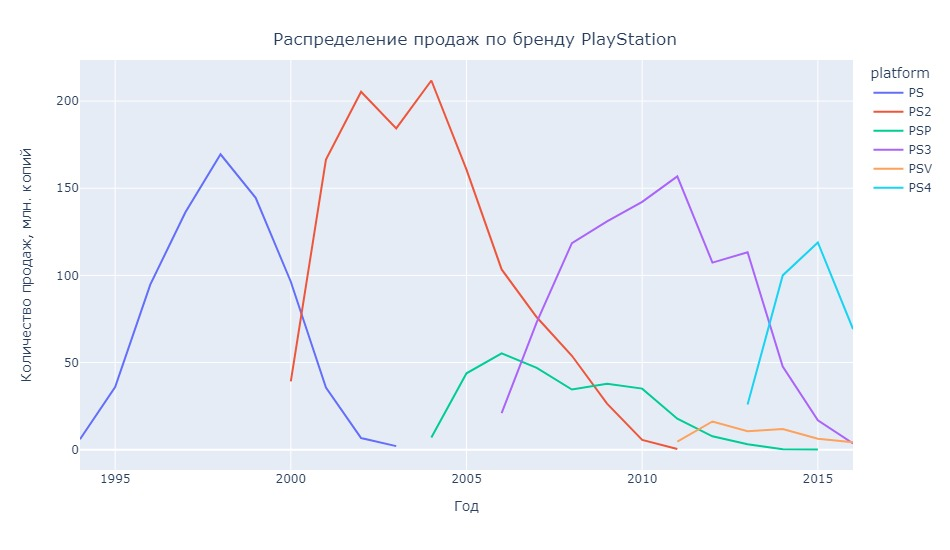

In [36]:
my_line('PlayStation')

Если не учитывать портативные консоли PSP и PSV то можно отметить что для PlayStation характерная продолжительность жизни каждого поколения консолей составляет примерно 10 лет. После выпуска консоли через 6 лет в свет выходит следующее поколение и в среднем через 3-4 года предыдущее поколение прекращает свое существование. Что касаемо портативных консолей, то здесь наблюдается аналогичная ситуация что и у полноценных консолей. Так же стоит отметить что в плане продаж самой успешной консолью в линейке PlayStation можно считать приставку PlayStation2, а наименее успешной из полноценных консолей - PlayStation4.

Проанализируем график распределения продаж по платформам Nintendo

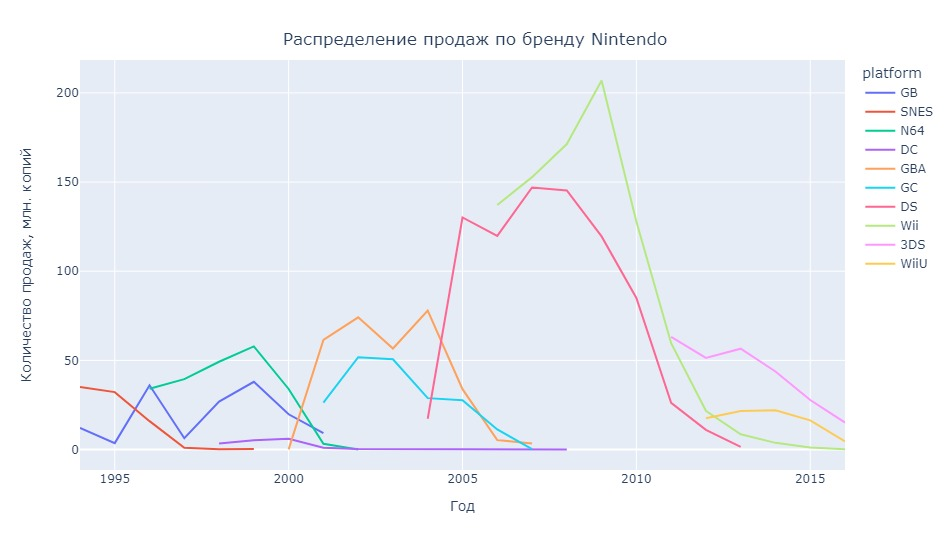

In [37]:
my_line('Nintendo')

По стационарным консолям Nintendo сложно определить среднюю продолжительность жизни. Четыре (SNES, N64, WiiU, GC) из 5-ти (+Wii) были не очень успешными в плане продаж. Консоль Wii стартовала с очень неплохого показателя продаж игр в 2006 году (видимо за счет игры Wii Sports), и этот показатель стремительно увеличивалася до 2009 года, а потом резко упал до нуля за 5 лет. Сменившая ее консоль WiiU стала на порядок менее популярной. Можно оценить продолжительность жизни консолей Nintendo в 6-7 лет, а смена поколений происходит в среднем за 1-3 года. 

Картина по портативным консолям Nintendo куда более приятная. Тут можно отметить явного лидера по продажам - Nintendo DS. Самой неудачной портативной консолью Nintendo можно считать Nintendo DC. Продолжительность жизни портативных консолей Nintendo составляет около 7-8 лет, а смена поколений происходит в среднем за 2 года.

Проанализируем график распределения продаж по платформам Xbox

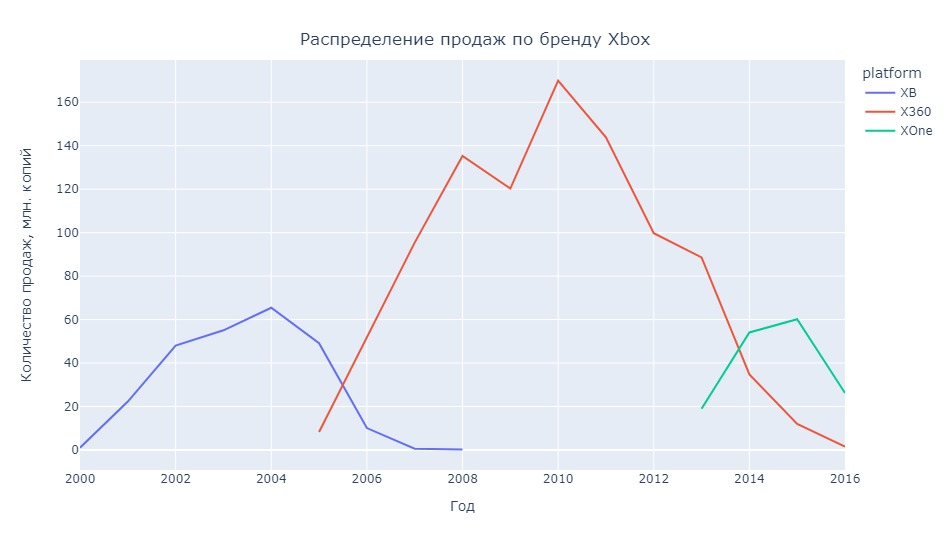

In [38]:
my_line('Xbox')

По платформам Xbox все гораздо проще. Здесь мы имеем всего 3 стационарные консоли, явным лидером из которых по продажам игр является Xbox360. Средний продолжительный срок жизни консолей колеблется от 8 до 11 лет, а смена поколений происходит за 3 года.

Проанализируем график распределения продаж по платформe PC

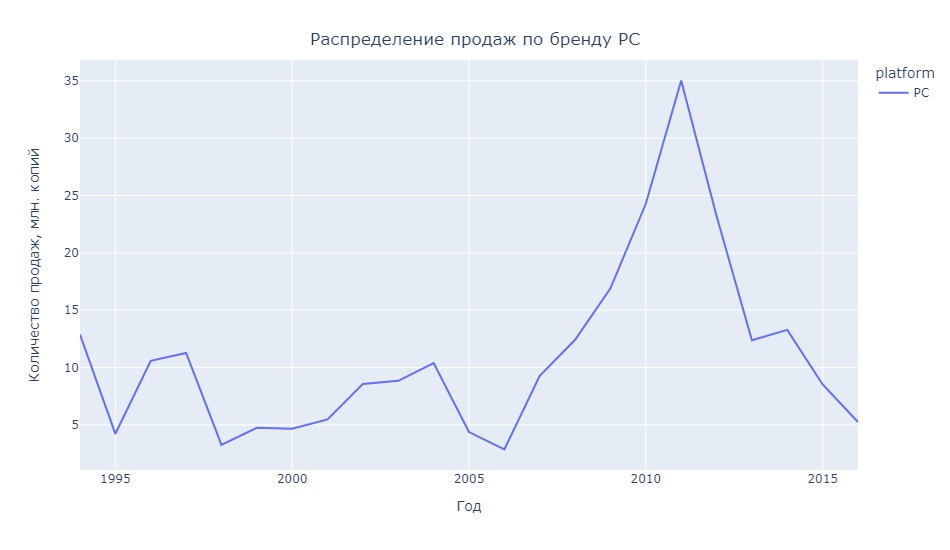

In [39]:
my_line('PC')

Продажи игр для PC характеризуются в основном так: все стабильно печально. Это за исключением периода с 2009 по 2013 год, когда продажи превысили 15 млн. копий. Вероятно такие продажи - следствие процветания пиратства на данной платформе.

В итоге можно отметить, что бесспорным фаворитом по количеству и стабильности продаж копий игр можно считать PlayStation, а сильно отставшей платформой по данным показателям является PC.

Для более наглядного сравнения построим график распределения продаж для топ 5-10 консолей. Более точное количество определим после выведения сводной таблицы.

In [40]:
top_platform = brends\
    .groupby('platform')['total_sales'].sum()\
    .sort_values(ascending=False)\
    .reset_index()
display(top_platform.head(10))

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.76
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Построим график распределения продаж по топ 6 платформам. В него у нас попадают три консоли PlayStation, одна Xbox и две Nintendo (одна из них, DS, портативная).

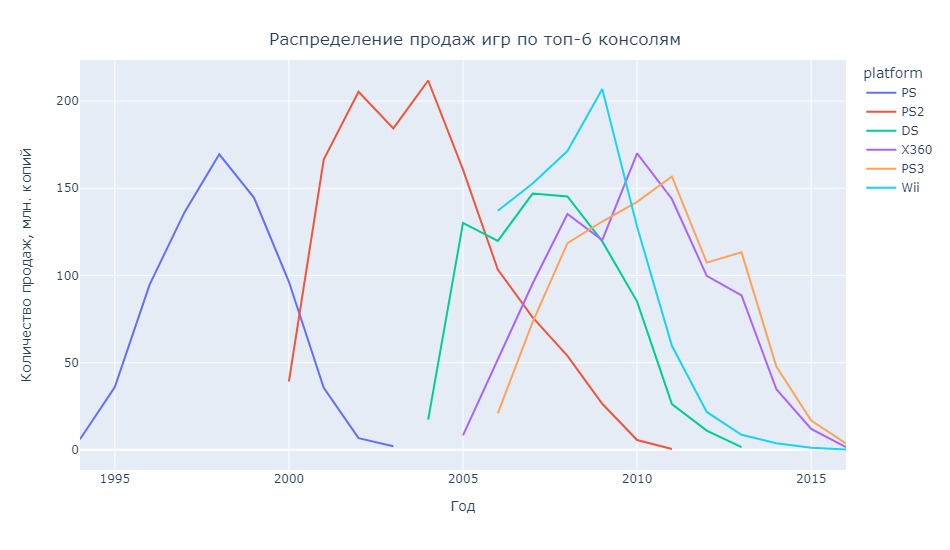

In [41]:
fig = px.line(brends[brends['platform'].isin(top_platform['platform'].head(6))],\
        x='release_year', y='total_sales', color='platform',\
        labels=dict(total_sales='Количество продаж, млн. копий', release_year='Год'))
fig.update_layout(title={'text': 'Распределение продаж игр по топ-6 консолям',\
        'y':0.94, 'x':0.5})
fig.show()

Как видно по графику доминирующую позицию по продажам копий игр в период с 1995 по 2006 год занимали консоли PlayStation. С 2006 года по 2015 три лидирующих брэнда делили рынок продаж игр примерно поровну. Но можно выделить в этот период брэнд Nintendo, он имел сразу две консоли, одна из которых (портативная) по продажам не уступала стационарным консолям других брэндов, а вторая (стационарная) имела резкий подъем количества проданных игр с 2006 по 2009 год, и еще более резкий спуск в оставшийся период.

#### Анализ суммарных продаж по годам

Для выбора актуального периода изучим распределение продаж игр по годам вне зависимомти от платформы

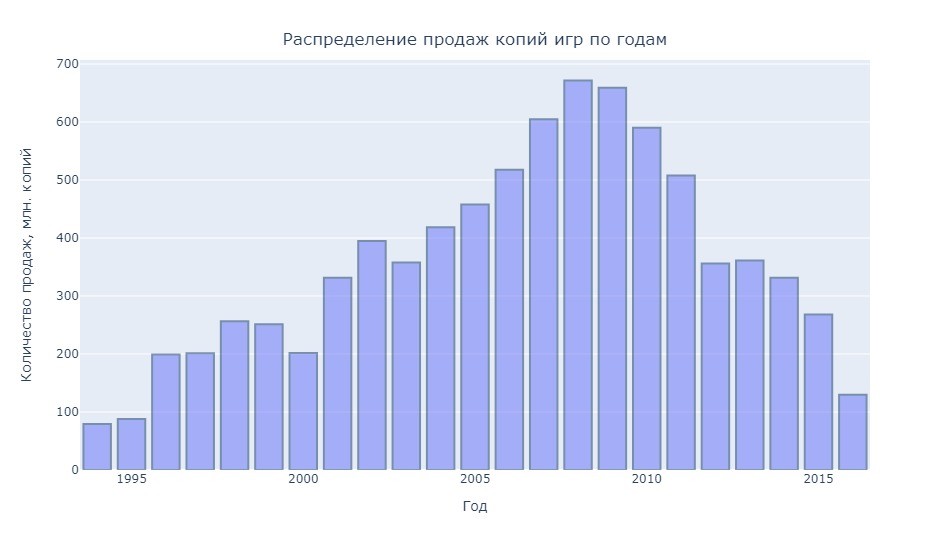

In [42]:
fig = px.bar(df_main.groupby(['release_year'])['total_sales'].sum()\
    .reset_index(), x='release_year', y='total_sales',\
     labels=dict(total_sales='Количество продаж, млн. копий', release_year='Год'))
fig.update_traces(marker_line_color='rgb(10,50,100)', marker_line_width=2, opacity=0.5)
fig.update_layout(title={'text': 'Распределение продаж копий игр по годам', 'y':0.94, 'x':0.5})
fig.show()

Период с 1994 года по 2016 год можно разделить на три части. С 1994 года по 2006 год включительно продажи игр постепенно выросли с менее 100 млн. копий в год до 520 млн. копий в год. В период с 2007 по 2010 год продажи находились выше 590 млн. копий в год. И начиная с 2011 года продажи начали резко падать к 2016 году до уровня 130 млн.копий в год. Но стоит отметить, что мы можем иметь не полную картину за 2016 год, что и наблюдается на графике. С 2012 года по 2015 год включительно продажи держались на уровне около 300 млн. копий в год, но уже в 2016 они упали более чем в 2 раза, что может говорить о неполноте данных за этот год.

#### Определение актуального периода для дальнейшего анализа

По графикам двух предшествующих подпунктов видно, что общее количество продаж копий игр для всех платформ держится примерно на одном уровне (около 300 млн. копий в год) с 2012 по 2015 год. Если рассматривать актуальный период со стороны даты выпуска последних моделей топ6-ти консолей, то видно что для PlayStation точкой отсчета будет 2013 год, для Nintendo - 2012 год, для Xbox - 2013 год. На соновании этих данных, принимаю актуальный период для дальнейшего анализа с 2012-го по 2016-й год включительно. Сохраним таблицу по выбраному периоду в отдельную переменную.

In [43]:
df_fin = df_main.query('2011 < release_year <= 2016')
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 16 to 16442
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          2885 non-null   object  
 1   platform      2885 non-null   object  
 2   release_year  2885 non-null   int16   
 3   genre         2885 non-null   object  
 4   na_sales      2885 non-null   float64 
 5   eu_sales      2885 non-null   float64 
 6   jp_sales      2885 non-null   float64 
 7   other_sales   2885 non-null   float64 
 8   critic_score  1311 non-null   float64 
 9   user_score    1530 non-null   float64 
 10  rating        2885 non-null   category
 11  total_sales   2885 non-null   float64 
 12  brend         2885 non-null   object  
dtypes: category(1), float64(7), int16(1), object(4)
memory usage: 279.1+ KB


#### Отбор потенциально прибыльных платформ

Для вывода необходимого графика распределения сохраним в отдельную переменную сгруппированную таблицу по годам и платформам с суммарными продажами

In [44]:
platform_year = df_fin\
    .groupby(['release_year', 'platform'])['total_sales'].sum()\
    .sort_values(ascending=False)\
    .reset_index()

Изучим график распределения продаж игр по каждой платформе в зависимости от года

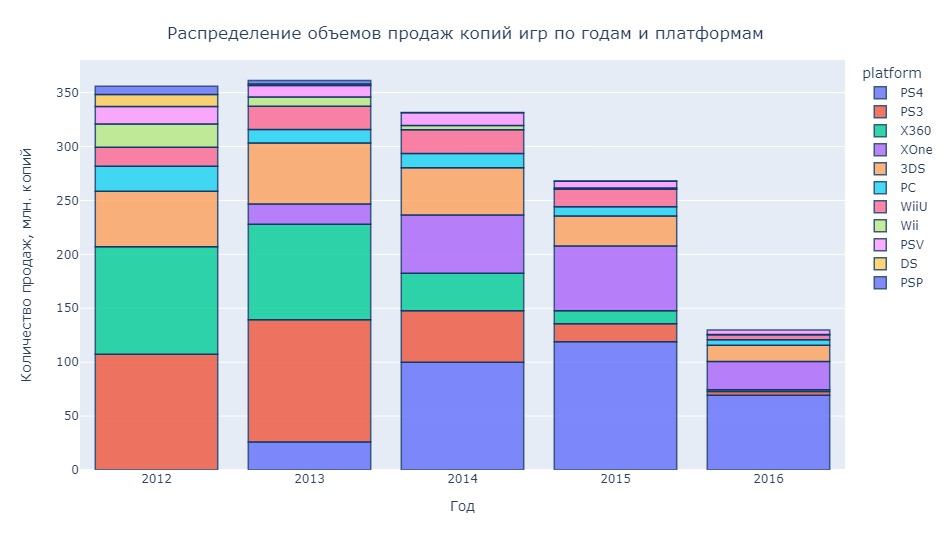

In [45]:
fig = px.bar(platform_year, x='release_year', y='total_sales', color='platform',\
             labels=dict(total_sales='Количество продаж, млн. копий', release_year='Год'))
fig.update_traces(marker_line_color='rgb(10,50,100)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title={'text': 'Распределение объемов продаж копий игр по годам и платформам',\
                         'y':0.95, 'x':0.49})
fig.show()

Проанализировав график можно сделать следующий вывод:
 - За весь период предварительно выделим 5 лидеров продаж: PS3, X360, 3DS, PS4, XOne.
 - В начале периода лидировала платформа PS3, но после 2013 года лидерство перешло к новому поколению платформы под названием PS4 и с каждым годом по данной платформе объем продаж копий игр только увеличивался, в то время как (что логично) объем продаж игр на платформу PS3 падал.
 - С незначительно меньшим объемом продаж в 2012 году была платформа X360. По ней, как и у лидера, аналогичная ситуация. В 2013 году ей на смену пришла новая платформа XOne и уже в 2014 году она обогнала предыдущую платформу по объемам продаж. Но стоит отметить что по платформе XOne рост продаж был не такой стремительный как у PS4, поэтому если в 2012 году объем продаж X360 был всего на 7% меньше чем у PS3, то в 2015 году объем продаж копий игр на XOne был на 49.4% меньше чем у PS4.
 - Так же стоит отметить портативную консоль от Nintendo, которая весь период составляла немалую долю общих продаж (например в 2012 году объем продаж составлял около 14% от общего количества). В 2012 году для этой платформы было продано более 51 млн.копий игр, в 2013 уже более 56 млн. копий, но в отличии от предыдущих платформ, к 2016 году продажи снизились до 28 млн. копий. Но тем неменее данная платформа занимает стабильное 3 место за весь выбраный период по объемам продаж.
 - В 2016 году картина сохраняется по распределению в топ3 платформ по объему продаж копий игр, но не стоит забывать, что возможно мы имеем дело с неполной картиной за данный год.

Сохраним в переменную df_top3 строки содержащие информацию по трем наиболее объемным по продажам платформам

In [46]:
df_top3 = df_fin[df_fin['platform'].isin(["PS4", "XOne", "3DS"])]
df_top3 = df_top3.reset_index()

#### График "ящик с усами" по глобальным продажам игр в разбивке по платформам

Построим график "ящик с усами" для трех потенциально прибыльных платформ

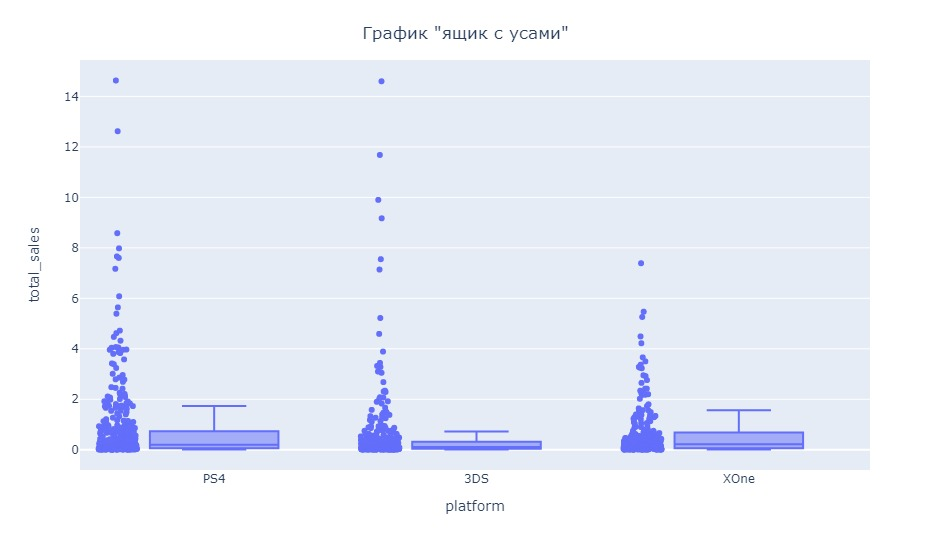

In [47]:
my_yc(df_top3, 'platform', 'total_sales')

Большая часть игр по количеству проданных копий для стационарных консолей имеет количество продаж в пределах 1.73 млн.копий, тогда как для портативной консоли 3DS этот предел составляет 0.72 млн. копий. Что примечательно, у консолей PS4 и 3DS имеется ряд успешных игр с количеством проданных копий превышающих 8 млн. в отличии от платформы XBox.

#### Влияние оценок на продажи игр для трех потенциально прибыльных платформ

Изучим графические и числовые матрицы корреляции между оценками критиков, оценками пользователей и количеством проданных копий по каждой игре для каждой платформы по отдельности без учета редких игр с высоким показателем продаж.

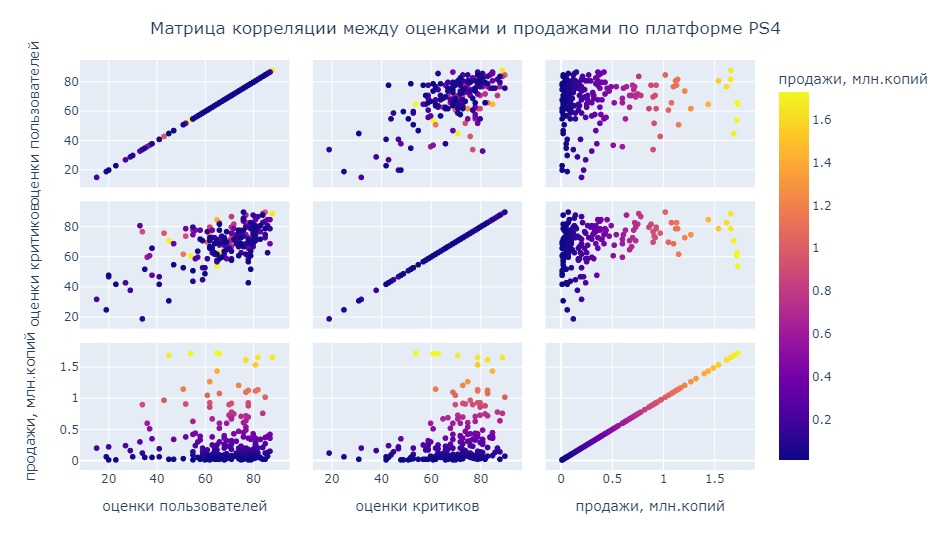

,user_score,critic_score,total_sales
user_score,1.000000,0.638477,0.032088
critic_score,0.638477,1.000000,0.264572
total_sales,0.032088,0.264572,1.000000


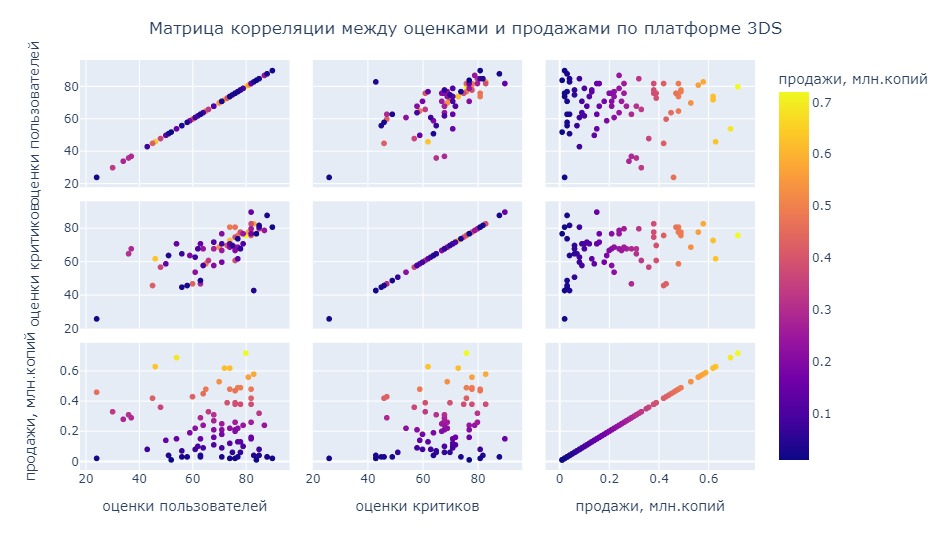

,user_score,critic_score,total_sales
user_score,1.000000,0.688112,-0.035538
critic_score,0.688112,1.000000,0.256657
total_sales,-0.035538,0.256657,1.000000


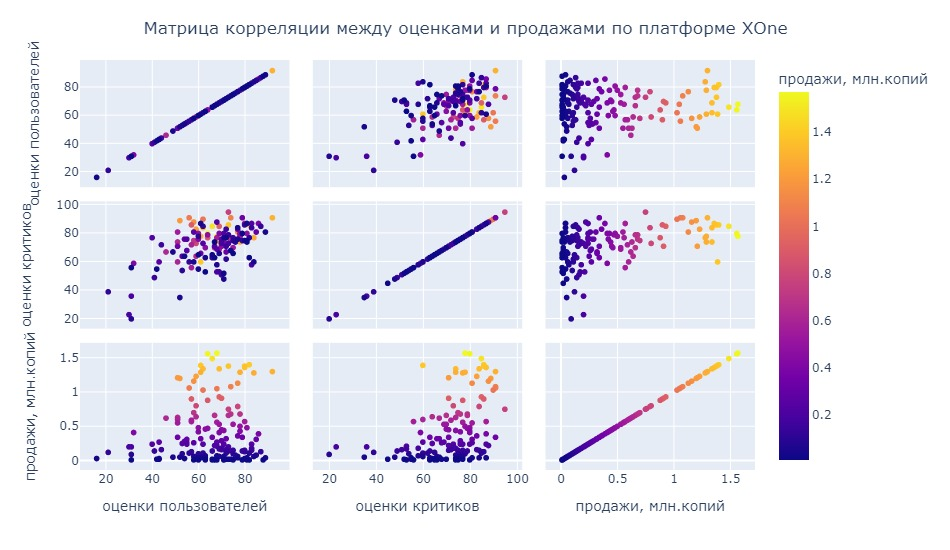

,user_score,critic_score,total_sales
user_score,1.000000,0.546567,0.070946
critic_score,0.546567,1.000000,0.421853
total_sales,0.070946,0.421853,1.000000


In [48]:
my_corr_score('PS4', 1.73)
my_corr_score('3DS', 0.72)
my_corr_score('XOne', 1.57)

- Платформа PS4

Как видно на матрице, существует сильная зависимость между оценками пользователей и критиков, но нас интересует не это. Как оказалось продажи игр для данной платформы не зависят от оценок пользователей, корреляция между показателями равняется 0.03. Так же заметно в отношении оценок пользователей, что имеется ряд игр с плохими оценками пользователей но с большим количеством продаж. В отношении оценок критиков ситуация обратная, корреляция с этим показателем сотставляет 0.64, что говорит о том что продажи игр имеют зависимость выше средней с оценками критиков.

- Платформа 3DS

Как видно на матрицах, продажи игр для данной платформы так же не зависят от оценок пользователей, корреляция между показателями равняется -0.04. Так же заметно в отношении оценок пользователей, что имеется ряд игр с плохими оценками пользователей но с большим количеством продаж, и это еще более ярко выражено чем у платформы PS4. В отношении оценок критиков ситуация так же обратная, корреляция с этим показателем сотставляет 0.69, что говорит о том что продажи игр имеют зависимость выше средней с оценками критиков.

- Платформа XOne

Как видно на матрицах, продажи игр для данной платформы так же не зависят от оценок пользователей, корреляция между показателями равняется 0.07. В отличии от PS4 и 3DS более продаваемые игры в данной платформе чаще имеют более высокие оценки пользователей. В отношении оценок критиков ситуация так же обратная, корреляция с этим показателем сотставляет 0.55, что говорит о том что продажи игр имеют среднюю зависимость с оценками критиков.

#### Анализ игровых жанров

Выведем график соотношения продаж игр в зависимости от жанра

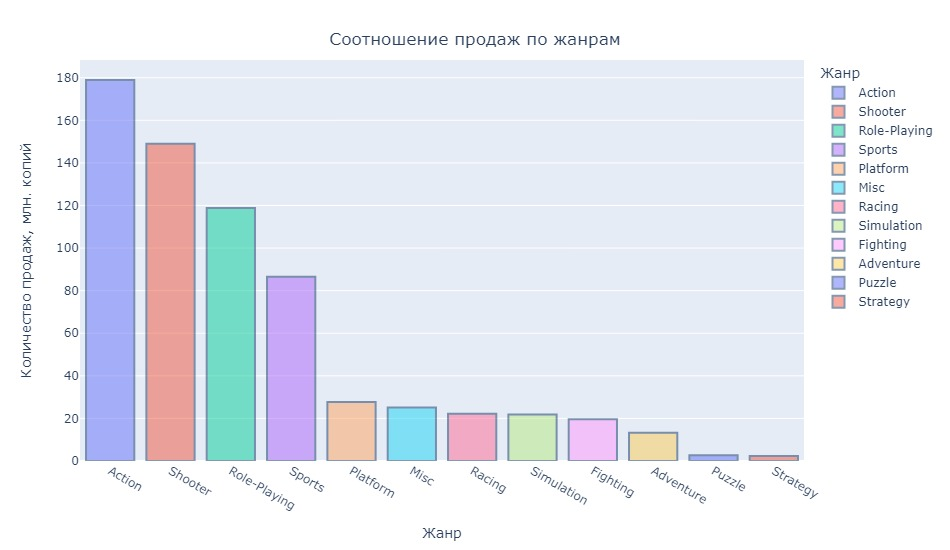

In [49]:
fig = px.bar(df_top3.groupby(['genre'])['total_sales'].sum()\
            .sort_values(ascending=False)
            .reset_index(), x='genre', y='total_sales',\
         labels=dict(total_sales='Количество продаж, млн. копий', genre='Жанр'),\
         color='genre')
fig.update_traces(marker_line_color='rgb(10,50,100)', marker_line_width=2, opacity=0.5)
fig.update_layout(title={'text': 'Соотношение продаж по жанрам', 'y':0.94, 'x':0.5})
fig.show()

Игровые жанры можно разбить на две категории по количеству продаж: жанры с высокими продажами (Action, Shooter, Role-Playing, Sports) и жанры с низкими продажами (Platform, Misc, Racing, Simulation, Fighting, Adventure, Puzzle, Strategy). В категории с высокими продажами явно выдеяются два жанра - Action и Shooter. В период с 2012 по 2016 их продажи превысили 140 млн. копий игр по каждому жанру. Так же стоит отметить два наименее популярных жанра - Puzzle и Strategy. В тот же период продажи копий игр данных жанров составили менее 5 млн. копий суммарно.

### Портрет геймера для каждого региона

#### Предпочтения пользователей регионов по платформам

Для определения пяти наиболее популярных платформ в период с 2012 по 2016 год в каждом регионе, сгруппируем необходимую таблицу и сохраним в отдельную переменную

In [50]:
platform_region = df_fin\
    .groupby('platform')['na_sales', 'eu_sales', 'jp_sales'].sum()\
    .reset_index()

На основании сгруппированной таблицы выведем топ-5 популярных платформ для каждого региона

In [51]:
top5(platform_region, 'platform', 'na_platform', 'eu_platform', 'jp_platform')

,rating,na_platform,na_sales,eu_platform,eu_sales,jp_platform,jp_sales
0,1,X360,140.05,PS4,141.09,3DS,87.79
1,2,PS4,108.74,PS3,106.85,PS3,35.29
2,3,PS3,103.38,X360,74.52,PSV,21.04
3,4,XOne,93.12,XOne,51.59,PS4,15.96
4,5,3DS,55.31,3DS,42.64,WiiU,13.01


Изучим соотношение популярности для каждой платформы в регионах

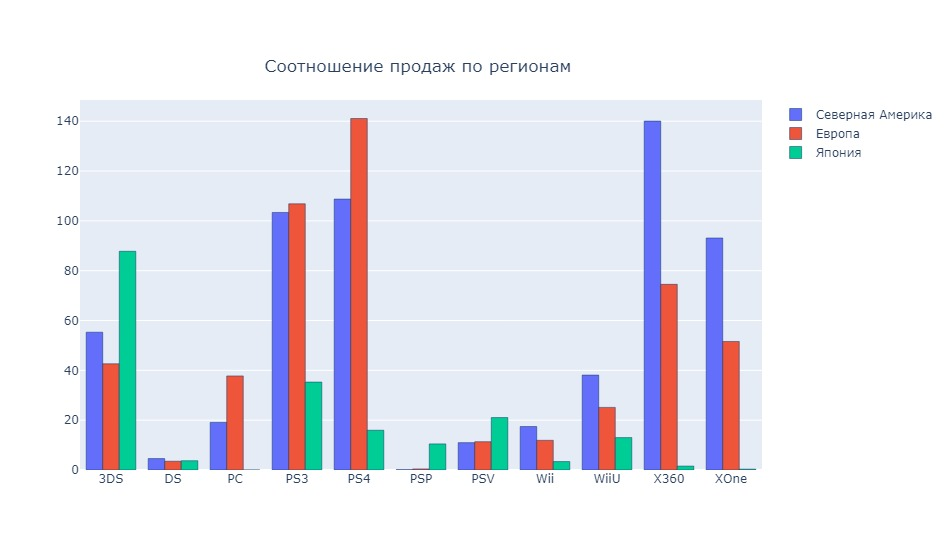

In [52]:
top_visual(platform_region, 'platform')

Проанализировав таблицу и график можно сделать следующие выводы:
 - Топ-5 популярных платформ для каждого региона различны.
 - В северной Америке по популярности с большим отрывом лидирует платформа X360. За ней расположились два поколения платформ от PlayStation, на 4 позиции с небольшим отрывом от PS находится обновленная версия XBox под названием XOne. Нижнюю строчку рейтинга занимает портативная консоль 3DS.
 - В Европе платформы по рейтингу расположились немного иным образом. Лидерами с большим отрывом являются платформы PlayStation, 3 и 4 позиции занимает Xbox, и так же как в северной Америке последнюю строчку занимает платформа 3DS.
 - Что касаем Японии, тут картина совершенно иная. Лидером с большим отрывом является платформа 3DS, за ней расположились три платформы PlayStation, а наиболее популярная в северной Америке платформа X360 совсем отсутствует в топ-5 платформ Японии.
 - Обобщив, можно заключить, что пользователи северной Америки предпочитают платформу Xbox, пользователи Европы - платформу PlayStation, а пользователи Японии - портативную платформу 3DS от Nintendo.

#### Предпочтения пользователей регионов по игровым жанрам

Для определения пяти наиболее популярных жанров в период с 2012 по 2016 год в каждом регионе, сгруппируем необходимую таблицу и сохраним в отдельную переменную

In [53]:
genre_region = df_fin\
    .groupby('genre')['na_sales', 'eu_sales', 'jp_sales'].sum()\
    .reset_index()

На основании сгруппированной таблицы выведем топ-5 популярных жанров для каждого региона

In [54]:
top5(genre_region, 'genre', 'na_genre', 'eu_genre', 'jp_genre')

,rating,na_genre,na_sales,eu_genre,eu_sales,jp_genre,jp_sales
0,1,Action,177.84,Action,159.34,Role-Playing,65.44
1,2,Shooter,144.77,Shooter,113.47,Action,52.80
2,3,Sports,81.53,Sports,69.08,Misc,12.86
3,4,Role-Playing,64.00,Role-Playing,48.53,Simulation,10.41
4,5,Misc,38.19,Racing,27.29,Fighting,9.44


Изучим соотношение популярности для каждого жанра в регионах

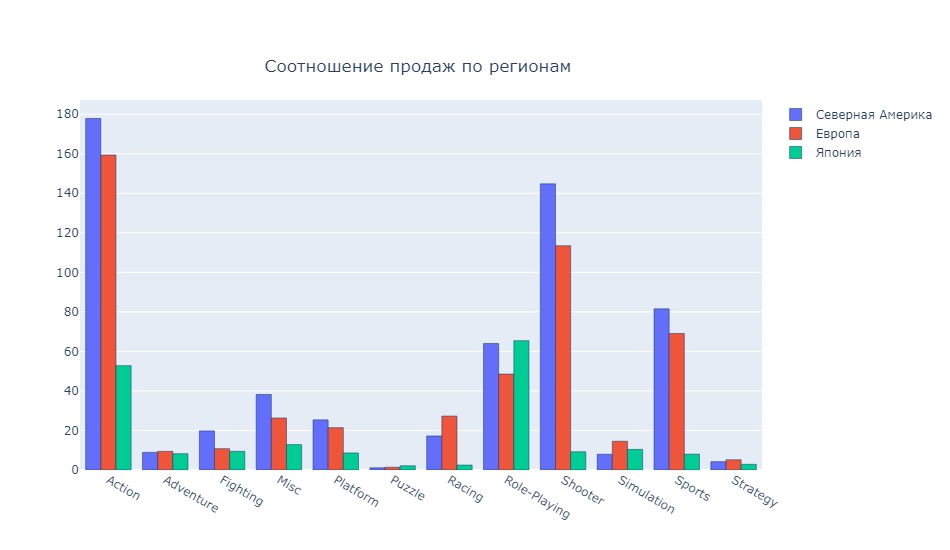

In [55]:
top_visual(genre_region, 'genre')

Проанализировав таблицу и график можно сделать следующие выводы:
- Предпочтения пользователей в жанрах для северной Америки и Европы одинаковые, в то же время в Японии совершенно иные предпочтения пользователей.
- Самыми популярными жанрами для северной Америки и Японии являются Action и Shooter. К менее популярным в данных регионах, но все же востребованным, относятся жанры Sports, Role-Playing, Misc и Racing.
- Для японии наиболее популярными жанрами с большим отрывом являются Role-Playing и Action. Так же в топ-5 популярных игровых жанров для японии входят Misc, Simulation и Fighting, но их популярность не столь велика.
- Для всех трех регионов можно выделить четыре наиболее популярных жанра: Action, Shooter, Sports и Role-Playing.

#### Влияние рейтинга ESRB на продажи в отдельном регионе

Для определения влияния возрастного рейтинга в период с 2012 по 2016 год в каждом регионе на продажи, сгруппируем необходимую таблицу и сохраним в отдельную переменную

In [56]:
esrb_region = df_fin\
    .groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum()\
    .reset_index()

На основании сгруппированной таблицы выведем для каждого региона отсортированные рейтинги по продажам

In [57]:
top5(esrb_region, 'rating', 'na_rating_esrb', 'eu_rating_esrb', 'jp_rating_esrb')

,rating,na_rating_esrb,na_sales,eu_rating_esrb,eu_sales,jp_rating_esrb,jp_sales
0,1,M,231.57,M,193.96,ND,108.84
1,2,E,114.37,E,113.02,E,28.33
2,3,ND,103.31,ND,91.50,T,26.02
3,4,E10+,75.70,E10+,55.37,M,21.20
4,5,T,66.02,T,52.96,E10+,8.19


Изучим соотношение продаж для каждого рейтинга в регионах

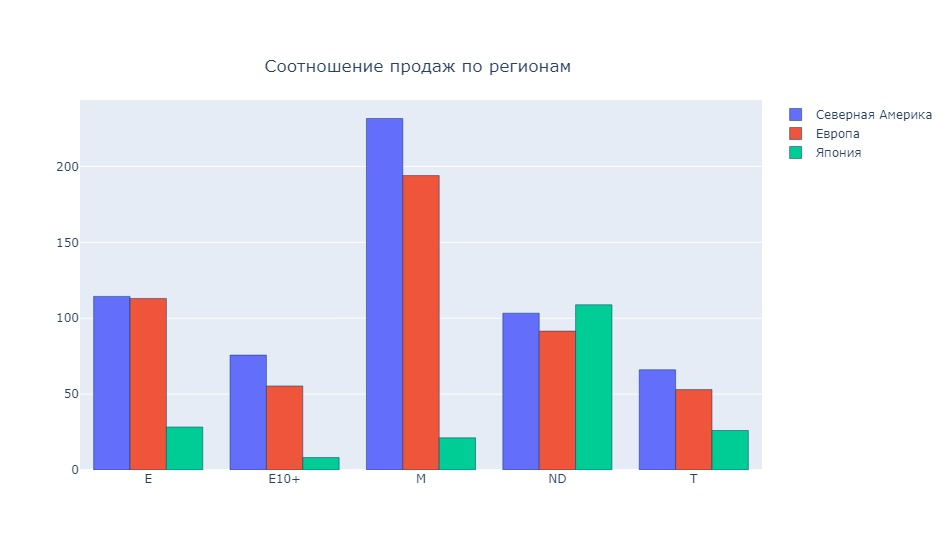

In [58]:
top_visual(esrb_region, 'rating')

Проанализировав таблицу и график можно сделать следующие выводы:
- Как в случае с жанрами, в отношении возрастных рейтингов ситуация аналогичная. Нет различия между северной Америкой и Европой, тогда как в Японии влияние рейтинга на продажи совершенно иное.
- В северной Америке и Европе просматривается четкая зависимость количества продаж от возрастного рейтинга. Наиболее продаваемыми играми в данных регионах можно считать игры с возрастным рейтингом "M" (Игра подходит для возрастной категории старше 17 лет). Такие игры в два раза больше продаются в северной Америке и в 1.7 раз в Европе, чем следующие по продоваемости игры с возрастным рейтингом "Е" (Игра подходит для возрастной категории старше 6 лет).
- В Японии наоборот, полностью отсутствует зависимость продаж от возрастного рейтинга, так как лидером по продажам здесь является неопределенный рейтинг, а остальные рейтинги продаются в одинаковом объеме, за исключением рейтинга "E10+" (Игра подходит для возрастной категории старше 10 лет). Данный рейтинг почему-то не очень популярен в Японии.

### Проверка гипотез

Для проверки гипотез подготовим две необходимые таблицы. Сохраним их в отдельных переменных и очистим от редких выбивающихся значений.

In [59]:
xbox_vs_pc = df_fin[df_fin['platform'].isin(["XOne", "PC"])].reset_index()
action_vs_sports = df_fin[df_fin['genre'].isin(["Action", "Sports"])].reset_index()

Для определения границ выброса выведем для обоих таблиц графики "ящик с усами"

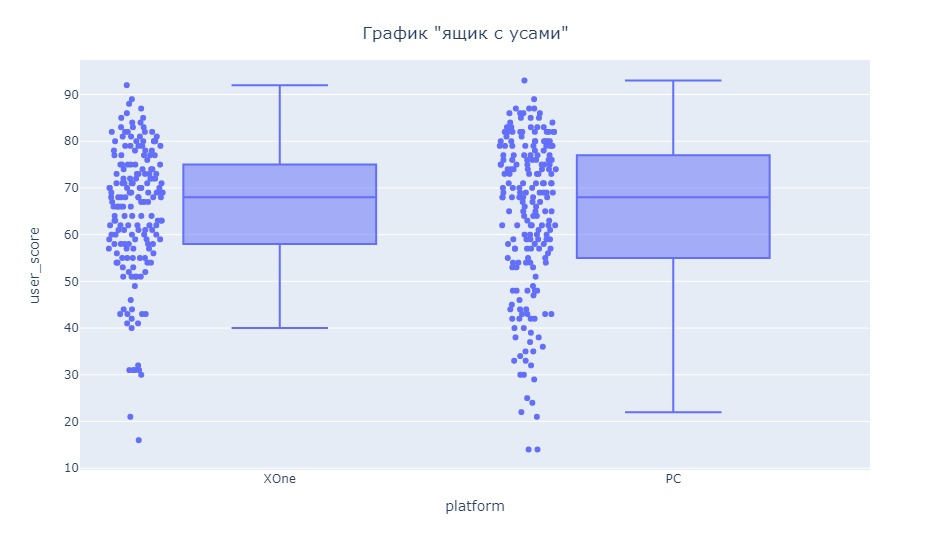

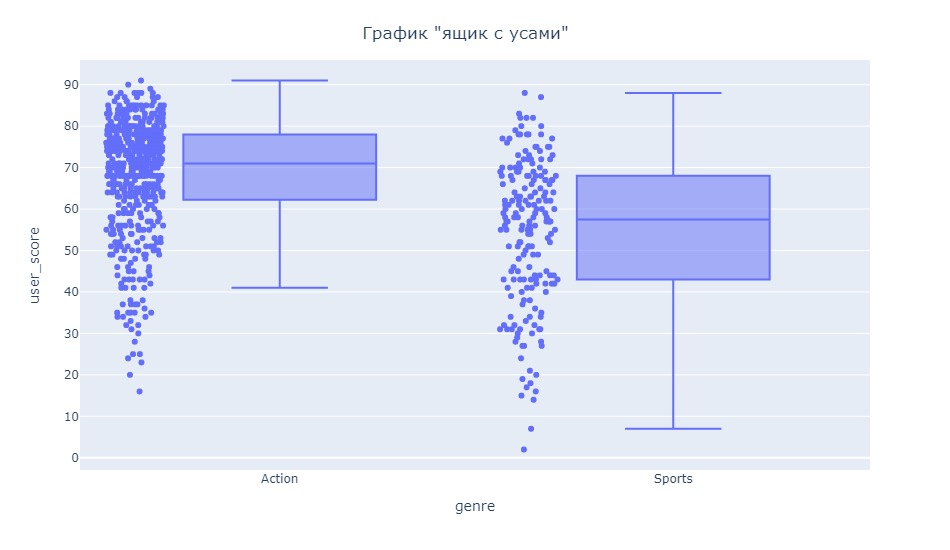

In [60]:
my_yc(xbox_vs_pc, 'platform', 'user_score')
my_yc(action_vs_sports, 'genre', 'user_score')

По двум сравниваемым платформам верхняя граница выбросов совпадает с максимальными оценками пользователей, но существует ряд оценок, которые находятся за нижней границей выброса, от них необходимо избавиться. По двум сравниваемым жанрам так же верхняя граница совпадает с максимальными оценками. Но по жанру Sports за нижней границей выброса оказалась всего одна игра, и как видно на графике по данному жанру широкий разброс пользовательских оценок. По жанру Action около 25 игр попали за нижнюю границу выбросов, по данному жанру разброс гораздо уже. В таблице сравниваемых жанров так же необходимо избавиться от выбросов.

In [61]:
xbox_vs_pc = xbox_vs_pc.query('(platform == "XOne" and user_score >= 40) or \
                               (platform == "PC" and user_score >= 22)')
action_vs_sports = action_vs_sports.query('(genre == "Action" and user_score >= 41) or \
                                           (genre == "Sports" and user_score >= 7)')

#### Сравнение пользовательских рейтингов платформ XOne и PC

Для отвержения/не отвержения гипотизы для начала сформулируем нулевую гипотизу так, чтобы в последствии рабочей гипотизой была альтернативная. Формулировка будет такая: Средние пользовательские рейтинги платформ XOne и PC различны.  На основании нулевой гипотизы сформулируем двухстороннюю альтернативную гипотезу: Средние пользовательские рейтинги платформ XOne и PC одинаковы. Для начала изучим распределения оценок пользователей для каждой платформы.

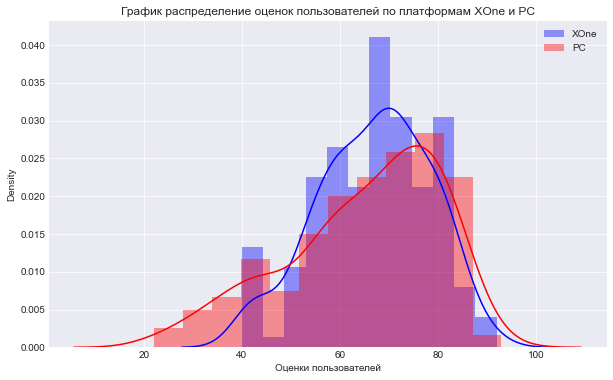

In [62]:
plt.figure(figsize=(10, 6))
sns.distplot(xbox_vs_pc.query('platform == "XOne"').user_score,\
             color='blue', label='XOne', kde=True, bins=12)
sns.distplot(xbox_vs_pc.query('platform == "PC"').user_score,\
             color='red', label='PC', kde=True, bins=12)
plt.title('График распределение оценок пользователей по платформам XOne и PC')
plt.xlabel('Оценки пользователей')
plt.legend() 
plt.show()

Для обоих платформ распределение нормальное, но для платформы PC оно смещено немного влево, имея небольшой хвост с противоположной стороны. Чтобы задать критический уровень статистической значимости измерим длинны генеральных выборок по каждой платформе.

In [63]:
print('Количество оценок по выборке для платформы XOne: ',\
     len(xbox_vs_pc.query('platform == "XOne"')))
print('Количество оценок по выборке для платформы PC: ',\
     len(xbox_vs_pc.query('platform == "PC"')))

Количество оценок по выборке для платформы XOne:  174
Количество оценок по выборке для платформы PC:  203


Изучим дисперсии выборок

In [64]:
print('Дисперсия оценок для платформы XOne: {:.1f}'\
      .format(xbox_vs_pc.query('platform == "XOne"').user_score.var()))
print('Дисперсия оценок для платформы PC: {:.1f}'\
      .format(xbox_vs_pc.query('platform == "PC"').user_score.var()))

Дисперсия оценок для платформы XOne: 130.6
Дисперсия оценок для платформы PC: 246.3


Объемы выборок больше 100. Принимаем критический уровень статистической значимости равный 0.01. Методу "scipy.stats.ttest_ind" мы передадим параметр "equal_var" со значенеием "False", так как различие между дисперсиями превышает 5%.

In [65]:
p_platform = st.ttest_ind(xbox_vs_pc.query('platform == "XOne"').user_score, \
                       xbox_vs_pc.query('platform == "PC"').user_score, equal_var=False)
alpha = 0.01
print('p-значение: {}'.format(p_platform.pvalue))
if p_platform.pvalue > alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.16802812079401414
Отвергаем нулевую гипотезу


p-значение оказалось достаточно высоким, что дает нам основание отвергнуть нулевую гипотезу, различия в оценках пользователей платформ статистически не значительны.

#### Сравнение пользовательских рейтингов  жанров Action  и Sports 

Для отвержения/не отвержения гипотизы для начала сформулируем нулевую гипотизу так, чтобы в последствии рабочей гипотизой была альтернативная. Формулировка будет такая: Средние пользовательские рейтинги жанров Action и Sports одинаковые. На основании нулевой гипотизы сформулируем двухстороннюю альтернативную гипотезу: Средние пользовательские рейтинги жанров Action и Sports различаются. Для начала изучим распределения оценок пользователей для каждого жанра.

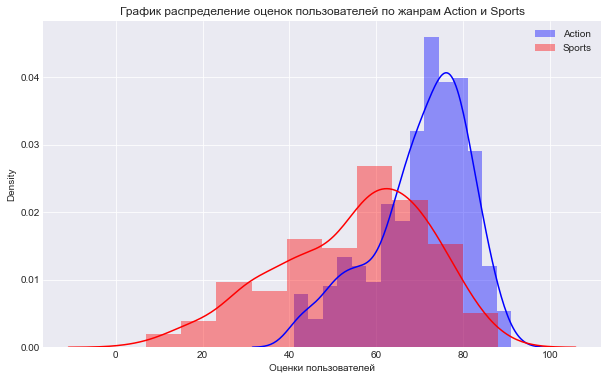

In [66]:
plt.figure(figsize=(10, 6))
sns.distplot(action_vs_sports.query('genre == "Action"').user_score,\
             color='blue', label='Action', kde=True)
sns.distplot(action_vs_sports.query('genre == "Sports"').user_score,\
             color='red', label='Sports', kde=True)
plt.title('График распределение оценок пользователей по жанрам Action и Sports')
plt.xlabel('Оценки пользователей')
plt.legend() 
plt.show()

Распределение нормальное. Для обоих жанров характерно смещение вправо с хвостом со стороны низких оценок. Чтобы задать критический уровень статистической значимости измерим длинны генеральных выборок по каждого жанра.

In [67]:
print('Количество оценок по выборке для жанра Action: ',\
     len(action_vs_sports.query('genre == "Action"')))
print('Количество оценок по выборке для жанра Sports: ',\
     len(action_vs_sports.query('genre == "Sports"')))

Количество оценок по выборке для жанра Action:  496
Количество оценок по выборке для жанра Sports:  193


Изучим дисперсии выборок

In [68]:
print('Дисперсия оценок для жанра Action: {:.1f}'\
      .format(action_vs_sports.query('genre == "Action"').user_score.var()))
print('Дисперсия оценок для жанра Sport: {:.1f}'\
      .format(action_vs_sports.query('genre == "Sports"').user_score.var()))

Дисперсия оценок для жанра Action: 120.6
Дисперсия оценок для жанра Sport: 291.0


Объемы выборок больше 100. Принимаем критический уровень статистической значимости равный 0.01. Методу "scipy.stats.ttest_ind" мы передадим параметр "equal_var" со значенеием "False", так как различие между дисперсиями превышает 5%.

In [69]:
p_genre = st.ttest_ind(action_vs_sports.query('genre == "Action"').user_score, \
                       action_vs_sports.query('genre == "Sports"').user_score, equal_var=False)
alpha = 0.01
print('p-значение: {}'.format(p_genre.pvalue))
if p_genre.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.9133152757321056e-25
Отвергаем нулевую гипотезу


p-значение оказалось мизерным, что дает нам основание отвергнуть нулевую гипотезу, существует статистически значимое различие в оценках пользователей обоих жанров.

### Вывод

В процессе подготовки проекта мы изучили общую информацию по таблице и написали вывод. На основании вывода мы удалили два дубликата,п роверили возможность заполнения пропусков в столбцах оценок пользователей и критикови в итоге пришли к выводу, что мы не имеем возможности заполнить данные пропуски чем либо. В столбце возрастного рейтинга мы заменили пропуски на ND (not defined), а так же скомпонавали категории. Так же, мы заменили в столбцах типы данных на необходимые и привели значения оценок пользователей к виду значений оценок критиков путем умножения значений на 10. В конце предобработки данных мы посчитали и добавили столбец суммарных продаж для каждой игры.

Во время проведения исследовательского анализа данных мы сделали следующие выводы:
- До 1994 года количество игр, выпускавшихся для всех платформ, не превышало 100 шт в год. После 1994 года этот показатель постепенно рос и в 2009 году достиг своего пика в 1400 шт в год.
- Топ-6 платформ с наибольшими суммарными продажами за весь период: PS, PS2, PS3, X360, DS, Wii.
- Для каждого бренда смена поколений и продолжительность жизни поколения разная. Например для PlayStation продолжительность жизни составляет 10 лет, а смена поколений происходит за 3-4 года; для Nintendo 7 лет и 2 года соответственно; для XBox 9 лет и 3 года соответственно.
- Опрределили актуальный период для дальнейшего анализа. Он расположился в пределах с 2012 года по 2016 год включительно.
- Выбрали потенциально прибыльные платформы вне зависимсти от региона. Ими оказались PS4, XOne и портативная 3DS.
- Определили, что продажи игр не зависят от оценок пользователей, но имеют зависимость выше средней от оценок критиков, при этом максимальная зависимоть достигается у консоли 3DS.
- Вне зависимости от региона выделели 4 жанра с наибольшим количеством проданных копий игр (Action, Shooter, Role-Playing и Sports) и два жанра с минимальным количеством продаж (Puzzle и Strategy).
- Вывели топ-5 платформ для каждого региона. Для Северной Америки и Европы ими оказались X360, PS4, PS3, XOne, 3DS, с разницей лишь в том, что в Северной Америке больше предпочитают платформы от XBox, а в Европе платформы PlayStation. В Японии рейтинг выглядит следующим образом: 3DS, PS3, PSV, PS4, WiiU.
- Наиболее продаваемыми играми для Северной Америки и Европы по жанрам стали Action и Shooter, а для Японии Role-Playing и Action.
- Определили влияние возрастного рейтинга на продажи. В Северной Америке и Европе наиболее продаваемыми являются игры для категории старше 17 лет. В Японии влияние возрастного рейтинга на продажи отсутствует.

Кроме того мы выдвинули две гипотезы, по результатам проверки которых мы определили, что различия между пользовательскими оценками игр платформы XOne и PC статистически незначимы, а пользовательские оценки жанров Action и Sports наоборот различны.

Заключение:
- Для Северной Америки перспективным направлением в плане продажи игр и проведения рекламных компаний будет платформа XOne с жанрами игр Action и Shooter.
- Для Европы перспективным направлением в плане продажи игр и проведения рекламных компаний будет платформа PS4 с жанрами игр Action и Shooter.
- Для Японии перспективным направлением в плане продажи игр и проведения рекламных компаний будет портативная платформа 3DS с жанрами игр Role-Playing и Action.